### Import required libraries


In [7]:
import torch
from PIL import Image, ImageDraw
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from kmeans_pytorch import kmeans
from skimage.color import label2rgb
from skimage.color import gray2rgb
from skimage.segmentation import slic, mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage import transform
from torch.autograd import Variable
from brain_eval import BrainDataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
from PIL import Image
from scipy.ndimage.filters import gaussian_filter

device = 'cuda'

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_16843/3800222237.py:20: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [8]:
def max_regarding_to_abs(a, b):
    c = np.zeros(a.shape)
    for i in range(len(a)):
        for j in range(len(a[0])):
            if abs(a[i][j]) >= abs(b[i][j]):
                c[i][j] = a[i][j]
            else:
                c[i][j] = b[i][j]
    return c

In [9]:
def convert_to_grayscale(im_as_arr):
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


### Required Functions

In [27]:
def grad_calc(input, model1, model2):

    data_var_sal = Variable(input).to(device)
    model1.zero_grad()
    if data_var_sal.grad is not None:
        data_var_sal.grad.data.zero_()
    data_var_sal.requires_grad_(True)
    lamda = 0.5
    criterion = nn.MSELoss()
    similarity_loss = torch.nn.CosineSimilarity()
    #---------------------------------------   
    output_pred = model1.forward(data_var_sal, type="activation")
    output_real = model2(data_var_sal)
    #---------------------------------------
    y_pred_1, y_pred_2, y_pred_3 = output_pred[1], output_pred[2], output_pred[3]
    y_1, y_2, y_3 = output_real[1], output_real[2], output_real[3]
    #---------------------------------------
    abs_loss_1 = criterion(y_pred_1, y_1)
    loss_1 = torch.mean(1 - similarity_loss(y_pred_1.view(y_pred_1.shape[0], -1), y_1.view(y_1.shape[0], -1)))
    abs_loss_2 = criterion(y_pred_2, y_2)
    loss_2 = torch.mean(1 - similarity_loss(y_pred_2.view(y_pred_2.shape[0], -1), y_2.view(y_2.shape[0], -1)))
    abs_loss_3 = criterion(y_pred_3, y_3)
    loss_3 = torch.mean(1 - similarity_loss(y_pred_3.view(y_pred_3.shape[0], -1), y_3.view(y_3.shape[0], -1)))
    total_loss = loss_1 + loss_2 + loss_3 + lamda * (abs_loss_1 + abs_loss_2 + abs_loss_3)
    #--------------------------------------
    model1.zero_grad()
    total_loss.backward()

    grad = data_var_sal.grad.data.detach().cpu()

    grad = np.asarray(grad.detach().cpu().squeeze(0))
    # grad = max_regarding_to_abs(np.max(grad, axis=0), np.min(grad, axis=0))
    # grad = np.expand_dims(grad, axis=0)
    grad = convert_to_grayscale(grad)
    if not isinstance(grad, np.ndarray):
            grad = grad.detach().cpu().numpy()

    img = input.detach().cpu().numpy().squeeze(0)
    saliency = np.asarray(grad) * img * 100
    saliency = max_regarding_to_abs(np.max(saliency, axis=0), np.min(saliency, axis=0))
    # print(grad.shape)

    return saliency


### Models structures 

In [22]:
class ResNet18EmbeddingRef(nn.Module):
    def __init__(self):
        super(ResNet18EmbeddingRef, self).__init__()
        resnet = resnet18(pretrained=True)
        
        # Extracting the layers up to Layer 4
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool

        # Residual layers
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4


    def forward(self, x):
        output = []
        
        # Initial layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)  # First ReLU
        x = self.maxpool(x)

        # Layer 1
        x = self.layer1(x)

        # Layer 2
        x = self.layer2(x)

        # Layer 3
        for block in self.layer3:
            residual = x
            # conv1 -> ReLU
            x = block.conv1(x)
            x = block.bn1(x)
            x = block.relu(x)  # Capture ReLU activation here
            output.append(x)  # Append ReLU output from Layer 3
            # conv2
            x = block.conv2(x)
            x = block.bn2(x)
            if hasattr(block, 'downsample') and block.downsample != None:
                residual = block.downsample(residual)
                x += residual

        # Layer 4
        for block in self.layer4:
            # conv1 -> ReLU
            residual = x
            x = block.conv1(x)
            x = block.bn1(x)
            x = block.relu(x)  # Capture ReLU activation here
            output.append(x)  # Append ReLU output from Layer 4
            # conv2
            x = block.conv2(x)
            x = block.bn2(x)
            if hasattr(block, 'downsample') and block.downsample != None:
                residual = block.downsample(residual)
                x += residual

        # Return the last 4 ReLU activations
        return output[-4:]
    

class ResNet18Embedding(nn.Module):
    def __init__(self):
        super(ResNet18Embedding, self).__init__()
        resnet = resnet18(pretrained=False)

       
        # Layer up to Layer 4
        self.layer4 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4
        )
        # Flatten the entire ResNet18 model
        # Average pooling and fully connected layer
        self.avgpool = resnet.avgpool

        # placeholder for the gradients
        self.gradients = None
        self.activation = None

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x, type=None):

        if type == "activation": 

            output = []
        
            for i,layer in enumerate(self.layer4): 
                if i<6 : 
                   x = layer(x)

                if(i==6): 
                   
                   # Layer 3
                   for target_layer, block in enumerate(layer):
                        residual = x
                        # conv1 -> ReLU
                        x = block.conv1(x)
                        x = block.bn1(x)
                        x = block.relu(x)  # Capture ReLU activation here
                        output.append(x)  # Append ReLU output from Layer 3
                        # conv2
                        x = block.conv2(x)
                        x = block.bn2(x)
                        if hasattr(block, 'downsample') and block.downsample != None:
                            residual = block.downsample(residual)
                            x += residual


                elif(i==7):     

                    # Layer 4
                    for target_layer, block in enumerate(layer):
                        # conv1 -> ReLU
                        residual = x
                        x = block.conv1(x)
                        x = block.bn1(x)
                        x = block.relu(x)  # Capture ReLU activation here
                        if(target_layer==1):
                            self.activation = x
                            h = x.register_hook(self.activations_hook)
                        output.append(x)  # Append ReLU output from Layer 4
                        # conv2
                        x = block.conv2(x)
                        x = block.bn2(x)
                        if hasattr(block, 'downsample') and block.downsample != None:
                            residual = block.downsample(residual)
                            x += residual

            # Return the last 4 ReLU activations
            return output[-4:]
            
        # Pass input through layers up to Layer 4
        x_prime = self.layer4(x)
        # Pass through average pooling
        if type == 'feature_map':
           
           return x_prime
        
        if type == 'embedding':
           
           x = self.avgpool(x_prime)
           # Flatten and pass through the fully connected layer
           x = x.view(x.size(0), -1)
        #    x = self.fc(x)
           return x 
        
        else : 
            x = self.avgpool(x_prime)
            # Flatten and pass through the fully connected layer
            x = x.view(x.size(0), -1)
            # x = self.fc(x)
            return x, x_prime

### Plot the original image 

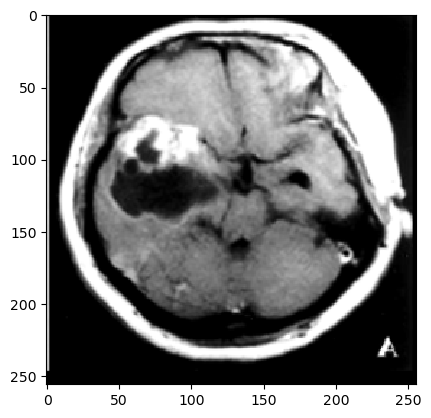

In [29]:

# # #for a random sample, get values
im="./test1.png" #set path to sample image
image = img_as_float(io.imread(im))
image = transform.resize(image, (256, 256))

plt.imshow(image)
plt.show()


### plot the results 

<All keys matched successfully>


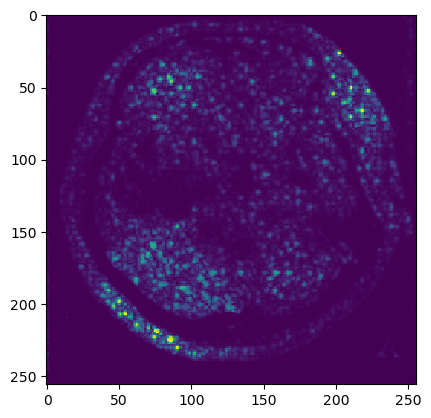

In [30]:
image = Image.open(im).convert('RGB')
#-----------------------
train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

image = train_transform(image).unsqueeze(0)
#------------------------
mod=ResNet18Embedding()
modi= torch.load('best_model_v2_brain_train_20epoch_25sep_salehi.tar')
msg = mod.load_state_dict(modi['state'])
mod = mod.cuda()
print(msg)
#----------------------
model_pretrained = ResNet18EmbeddingRef().cuda()
heat_map = grad_calc(image, mod, model_pretrained)
#---------------------------------
plt.imshow(heat_map, cmap='gray')
plt.show()